<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Библиотеки, настройки и функции

### Библиотеки

In [1]:
import os
import warnings
import time
import re

from tqdm import notebook

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize

import pymorphy2

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

from sklearn.metrics import accuracy_score, balanced_accuracy_score, \
    roc_auc_score, f1_score, confusion_matrix, roc_curve, auc, \
    precision_recall_curve, average_precision_score, \
    precision_score, recall_score

### Config

In [2]:
DATA_PATH1 = "toxic_comments.csv"
DATA_PATH2 = "/datasets/toxic_comments.csv"


TEXT_RULE = r'[^a-zA-Z\' \\n]'
LINK_PATT = r"http[s]?:\/(?:\/[^\/]+){1,}(?:\/[a-zA-Z\w ]+\.[a-z]{3,5}(?![\/]|[\wa-zA-Z]))"

NON_LATIN_PATT = r"[\uAC00-\uD7AF\u1100-\u11FF\u3130-\u318F\uA960-\uA97F\uD7B0-\uD7FF\uFFA1-\uFFDC\u0400-\u04FF\u4E00-\u9FFF\u3040-\u309F\u30A0-\u30FF]+"


STOP_WORDS = set(stopwords.words('english'))
MORPH = pymorphy2.MorphAnalyzer()


RANDOM_STATE = 42
VAL_SIZE = 0.2
TEST_SIZE = 0.2


PALETTE = {0: '#008744', 1: '#d62d20'}


sns.set_theme(style="white")

pd.options.display.max_rows = 1024
pd.options.display.max_columns = 1024
pd.set_option('display.max_colwidth', 128)


warnings.filterwarnings('ignore')

### Функции

#### Замер времени

In [3]:
def exec_time(start, end):
    '''
    This function calculates the difference between two given datetime objects
    and returns the difference in the format of HH:MM:SS.

    Parameters
    start: datetime object
    end: datetime object
    Returns
    diff_time (str): The difference between the two given datetime objects in
                     the format of HH:MM:SS.
    '''
    diff_time = end - start
    m, s = divmod(diff_time, 60)
    h, m = divmod(m, 60)
    s,m,h = int(round(s, 0)), int(round(m, 0)), int(round(h, 0))

    return "Completed for {0:02d}:{1:02d}:{2:02d}".format(h, m, s)

#### Работа с данными

In [4]:
def df_quik_view(df, asc=False, print_time=True):
    '''
    This function provides a quick overview of the input DataFrame by
    returning a summary table containing information such as number of
    unique values, missing values, data type, completeness percentage, and
    unique values of each column in the DataFrame. It also prints general 
    information such as the shape of the table, the number and percentage of
    duplicates in the table, and the memory usage of the table.
    
    Parameters:
    df (pd.DataFrame): a pandas DataFrame to analyze.
    asc (bool): a boolean value indicating whether to sort unique values in
                ascending order. Default is False, which means descending order.
    
    Returns:
    pd.DataFrame: a summary table of the input DataFrame containing the number
                  of unique values, missing values, data type, completeness
                  percentage, and unique values of each column.
    '''
    start = time.time() if print_time else None

    unique_values = []
    for i in df.columns:
        unique_values.append(df[i].sort_values(ascending=asc).unique())

    nans = df.isna().sum()
    table_scan = pd.DataFrame(
        {
            'values_num':    df.count(),
            'nulls_num':     df.isna().sum(),
            'completeness':  100 - (nans / (nans + df.notna().sum()) * 100),
            'uniques_num':   df.nunique(),
            'unique_values': unique_values,
            'dtype':         df.dtypes
        }
    )

    df_shape = df.shape
    duplicates = df.duplicated().sum()
    memory = df.memory_usage(index=False).sum() / 1_000_00
    print('General data analysis:')
    print()
    print('Shape of the table:     ', df_shape)
    print('Duplicates in the table: {}, ({}%)'
          .format(duplicates, round(duplicates / df_shape[0], 4) * 100)
         )
    print('Memory usage:            ' + str(round(memory, 1)) + '+ MB')
    print()

    if print_time:
        end = time.time()
        print('\n')
        print("======================")
        print(exec_time(start, end))
        print("======================")
    
    return table_scan

In [5]:
def format_text(text, rule):
    return re.sub(r"\s+", " ", re.sub(rule, ' ', text.lower())).strip()

In [6]:
def tokenize_text(text):
    sentences = sent_tokenize(text)
    tokens = []
    for sentence in sentences:
        sentence_tokens = word_tokenize(sentence)
        sentence_tokens = [token for token in sentence_tokens if token not in STOP_WORDS]
        lemmas = [MORPH.parse(token)[0].normal_form for token in sentence_tokens]
        tokens.extend(lemmas)
    return ' '.join(tokens)

In [7]:
def split_dataset(X, y, validation_size, test_size,
                  shuffle=None, stratify_y=True, random_state=42):
    stratify_ = y if stratify_y else None

    X_train, X_remaining, y_train, y_remaining = train_test_split(
        X, y, test_size=(validation_size + test_size), shuffle=shuffle,
        stratify=stratify_, random_state=random_state)

    stratify_ = y_remaining if stratify_y else None    
    X_val, X_test, y_val, y_test = train_test_split(
        X_remaining, y_remaining, test_size=(
            test_size / (validation_size + test_size)),
        shuffle=shuffle, stratify=stratify_, random_state=random_state)
    
    print("Train sample shape:      ", X_train.shape)
    print("Validation sample shape: ", X_val.shape)
    print("Test sample shape:       ", X_test.shape)
    
    return X_train, X_val, X_test, y_train, y_val, y_test

In [8]:
def preprocess_text(text):
    return TOKENIZER(text["text"], truncation=True)

#### Метрики

In [9]:
def compute_metrics(model, X_test, y_test, threshold=0.5):
    y_pred = model.predict_proba(X_test)
    y_pred = (y_pred[:, 1] >= threshold).astype(int)
    
    accuracy = accuracy_score(y_test, y_pred)
    balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    auc_score = roc_auc_score(y_test, y_pred_proba)
    gini = 2 * auc_score - 1
    
    metrics = {
        'Accuracy': accuracy,
        'Balanced Accuracy': balanced_accuracy,
        'F1 Score': f1,
        'Precision': precision,
        'Recall': recall,
        'GINI': gini,
        'AUC': auc_score
    }
    
    return metrics

In [10]:
def plot_confusion_matrix(model, X_test, y_test, figsize=(6, 10), threshold=0.5):
    y_pred = model.predict_proba(X_test)
    y_pred = (y_pred[:, 1] >= threshold).astype("int64")

    cm = confusion_matrix(y_test, y_pred)
    
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=figsize)
    
    ax1 = axes[0]
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True, ax=ax1)
    ax1.set_xlabel('Predicted')
    ax1.set_ylabel('Actual')
    ax1.set_title('Confusion Matrix (Absolute)')
    
    ax2 = axes[1]
    cm_norm = cm / cm.sum(axis=1, keepdims=True)
    sns.heatmap(cm_norm, annot=True, fmt='.2%', cmap='Blues', cbar=True, ax=ax2)
    ax2.set_xlabel('Predicted')
    ax2.set_ylabel('Actual')
    ax2.set_title('Confusion Matrix (Normalized)')
    
    plt.tight_layout()
    plt.show()

In [11]:
def plot_roc(model, X_test, y_test, figsize=(8, 6)):
    y_prob = model.predict_proba(X_test)[:, 1]
    
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=figsize)
    plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

In [12]:
def plot_precision_recall(model, X_test, y_test, figsize=(8, 6)):
    y_prob = model.predict_proba(X_test)[:, 1]
    
    precision, recall, _ = precision_recall_curve(y_test, y_prob)
    average_precision = average_precision_score(y_test, y_prob)
    
    plt.figure(figsize=figsize)
    plt.step(recall, precision, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall Curve (AP = %0.2f)' % average_precision)
    plt.show()

In [13]:
def plot_probabilities(model, X_test, y_test, figsize=(8, 6)):
    y_prob = model.predict_proba(X_test)[:, 1]
    df = pd.DataFrame({'Probability': y_prob, 'Actual': y_test})
    
    plt.figure(figsize=figsize)
    sns.histplot(data=df, x='Probability', hue='Actual', kde=True, bins="doane",
                 palette={0: '#008744', 1: '#d62d20'})
    plt.xlabel('Probability')
    plt.ylabel('Count')
    plt.title('Distribution of Predicted Probabilities')
    plt.legend(title='Actual')
    plt.show()

In [14]:
def find_optimal_threshold(model, features, target, metric, start=0, stop=1, step=0.01, silent=False):
    best_threshold = 0
    best_metric = 0
    
    for i, threshold in enumerate(np.arange(start, stop, step)):
        current_metric = compute_metrics(
            model_lr, X_test, y_test, threshold)[metric]
        if current_metric > best_metric:
            best_metric = current_metric
            best_threshold = threshold
        if not silent:
            print(f"Iteration {i}. Metric: {metric}. Threshold: {threshold}. Best threshold: {best_threshold} Current metric: {current_metric}. Best metric: {best_metric}")
    print()
    print()
    print()
    print()
    print(f"Metric:               ", metric)
    print(f"Best metric value:    ", best_metric)
    print(f"Best threshold value: ", best_threshold)

    return best_threshold

## Подготовка

In [15]:
if os.path.exists(DATA_PATH1):
    data = pd.read_csv(DATA_PATH1)
elif os.path.exists(DATA_PATH2):
    data = pd.read_csv(DATA_PATH2)
else:
    raise Exception("Path doesn't exist!")

data

,Unnamed: 0,text,toxic
0,0,"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closur...",0
1,1,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11, 2016 (UTC)",0
2,2,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking ...",0
3,3,"""\nMore\nI can't make any real suggestions on improvement - I wondered if the section statistics should be later on, or a su...",0
4,4,"You, sir, are my hero. Any chance you remember what page that's on?",0
...,...,...,...
159287,159446,""":::::And for the second time of asking, when your view completely contradicts the coverage in reliable sources, why should ...",0
159288,159447,You should be ashamed of yourself \n\nThat is a horrible thing you put on my talk page. 128.61.19.93,0
159289,159448,"Spitzer \n\nUmm, theres no actual article for prostitution ring. - Crunch Captain.",0
159290,159449,And it looks like it was actually you who put on the speedy to have the first version deleted now that I look at it.,0


In [16]:
df_quik_view(data)

General data analysis:

Shape of the table:      (159292, 3)
Duplicates in the table: 0, (0.0%)
Memory usage:            38.2+ MB



Completed for 00:00:01


,values_num,nulls_num,completeness,uniques_num,unique_values,dtype
Unnamed: 0,159292,0,100.0,159292,"[159450, 159449, 159448, 159447, 159446, 159445, 159444, 159443, 159442, 159441, 159440, 159439, 159438, 159437, 159436, 159...",int64
text,159292,0,100.0,159292,[﻿Sensual Pleasures of the MindItalic text\n\nThere are endless creative ways to provoke and capture sensual feelings. Money...,object
toxic,159292,0,100.0,2,"[1, 0]",int64


In [17]:
data = data[["text", "toxic"]]

### EDA

In [18]:
data["string_len"] = data["text"].apply(lambda x: len(re.sub(" *", "", x)))
data.sort_values(by="string_len").head(10)

,text,toxic,string_len
119018,"""""""",1,3
137400,"== """"""",0,5
136820,~ J.Lo,0,5
52336,"14:53,",0,6
118650,FUCK YOU,1,7
15432,"Howdy!""",0,7
120868,you suck,1,7
109794,{{unbloc,0,8
134053,YOU\n\n CUNT,1,9
150648,"04:59, 22 Au",0,10


In [19]:
data[data['text']
     .str
     .contains(re.compile(NON_LATIN_PATT), regex=True)
     ].sort_values(by="string_len")

,text,toxic,string_len
141389,Sorry \n\n对不起 (sorry),0,17
37619,"""\nSounds good.— (竜龍) """,0,19
65729,"""\nGroovy, thanks. 說嗎? """,0,20
154929,"Dear Jeff G. ツ, BLOW ME FAG!",1,22
99924,There are also and ... (討論),0,22
52489,"""\nAgree with here. 連絡 見学/迷惑 """,0,24
120789,"""\nForget about that ђɥл₮₴Ṝ """,0,24
122166,That's what I agree with. ← ну?,0,25
6488,"Lol, my major issue P:)) спойт",0,25
142152,"'s okay, I finally got one. 雲‍水",0,26


Target distribustion:



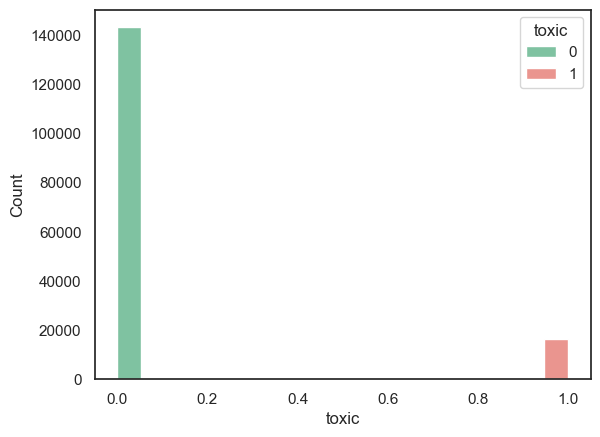

0    0.898388
1    0.101612
Name: toxic, dtype: float64


In [20]:
print("Target distribustion:")
print()
sns.histplot(data=data, x="toxic", hue="toxic", palette=PALETTE)
plt.show()
print(data["toxic"].value_counts(normalize=True))

In [21]:
data["string_len"].describe()

count    159292.000000
mean        326.883955
std         491.703226
min           3.000000
25%          80.000000
50%         170.000000
75%         361.000000
max        4967.000000
Name: string_len, dtype: float64

### Обработка

In [22]:
%%time

data_formatted = data.copy().drop("string_len", axis=1)

data_formatted["text"] = data_formatted["text"].apply(
    lambda x: format_text(x, TEXT_RULE))
data_formatted.sample(10)

CPU times: total: 2.98 s
Wall time: 3.4 s


,text,toxic
34491,lead the last sentence of the third paragraph is quite long and complex grammatically perhaps it could be rewritten or broke...,0
112632,big boned reference should be made to the controversy of someone who is big boned being an advocate of health,0
126341,hardware data sheet,0
41043,please write to me about this issue on the article's talk page not here it's not a personal issue consensus determined that ...,0
41569,i was just asking something i was just asking him something why did you treat it as personal attack,0
62159,the meaning of the word the word was used by uyghurs thus is used in turkic languages too yasa means even in current turkish...,0
103220,from wp competence where we very often see big controversies though is with editors who are disruptive while trying to help ...,0
62276,thank you for your input when i violate the cvu's policies of being uncivil to vandals or biting newcomers i will aquiese to...,0
118003,im just making a point rangers old retired the number in honour of fans rangers sevco scotland newco the tribute act are usi...,0
75792,don't start me off on the orthopod jokes ok just one what's a double blind trial two orthopods looking at a chest x ray t lk,0


### Разбиение на выборки

In [23]:
X_train, X_test, y_train, y_test = train_test_split(
    data_formatted["text"], data_formatted["toxic"], test_size=TEST_SIZE,
    shuffle=True, stratify=data_formatted["toxic"], random_state=RANDOM_STATE)

### Векторизация текстов с помощью TF-IDF

In [24]:
%%time

print("Tokenization started")
X_train = X_train.apply(tokenize_text)
print("                                              Train sample tokenized...")
X_test = X_test.apply(tokenize_text)
print("                                               Test sample tokenized...")
print("Done.")

Tokenization started
                                              Train sample tokenized...
                                               Test sample tokenized...
Done.
CPU times: total: 2min 7s
Wall time: 2min 14s


In [25]:
%%time

model_tf_idf = TfidfVectorizer()
model_tf_idf.fit(X_train)

X_train = model_tf_idf.transform(X_train)
X_test = model_tf_idf.transform(X_test)

print("Train sample shape:      ", X_train.shape)
print("Test sample shape:       ", X_test.shape)

Train sample shape:       (127433, 147617)
Test sample shape:        (31859, 147617)
CPU times: total: 6.45 s
Wall time: 7 s


## Обучение

### Логистическая регрессия

In [26]:
%%time

model_lr = LogisticRegression(class_weight="balanced",
                              random_state=RANDOM_STATE)
model_lr.fit(X_train, y_train)

compute_metrics(model_lr, X_train, y_train)

CPU times: total: 10.2 s
Wall time: 4.21 s


{'Accuracy': 0.962780441486899,
 'Balanced Accuracy': 0.9651761286896403,
 'F1 Score': 0.8409296709930577,
 'Precision': 0.7432416409769979,
 'Recall': 0.9681828712641903,
 'GINI': 0.9849516698035434,
 'AUC': 0.9924758349017717}

In [27]:
lr_res = compute_metrics(model_lr, X_test, y_test)
lr_res

{'Accuracy': 0.9430930035468784,
 'Balanced Accuracy': 0.90079005788423,
 'F1 Score': 0.7516778523489933,
 'Precision': 0.6751968503937008,
 'Recall': 0.8476984862527032,
 'GINI': 0.9416874131551443,
 'AUC': 0.9708437065775721}

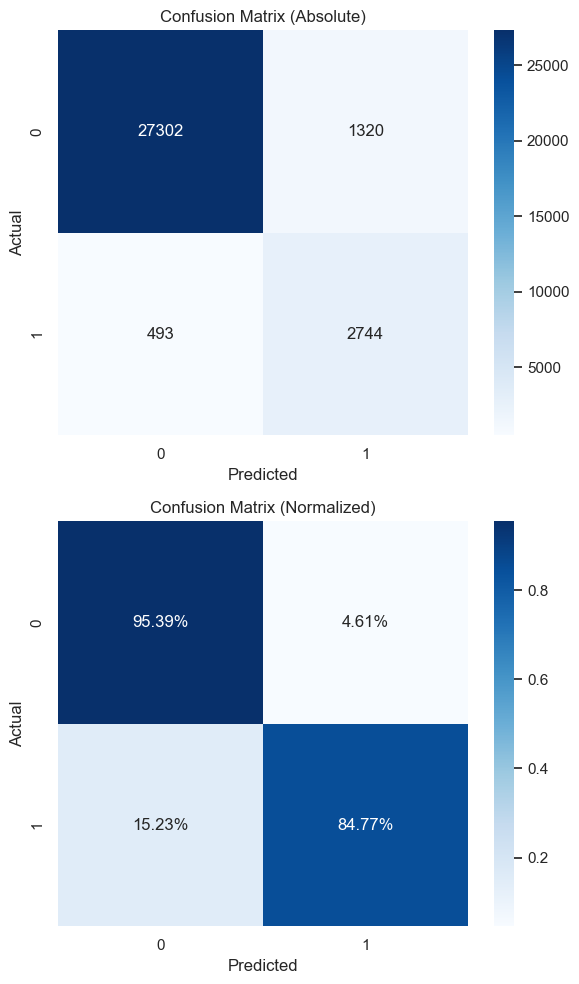

In [28]:
plot_confusion_matrix(model_lr, X_test, y_test)

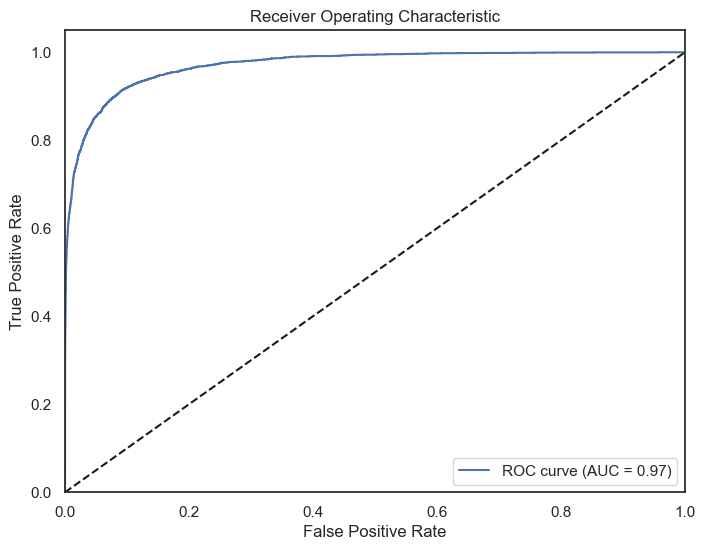

In [29]:
plot_roc(model_lr, X_test, y_test)

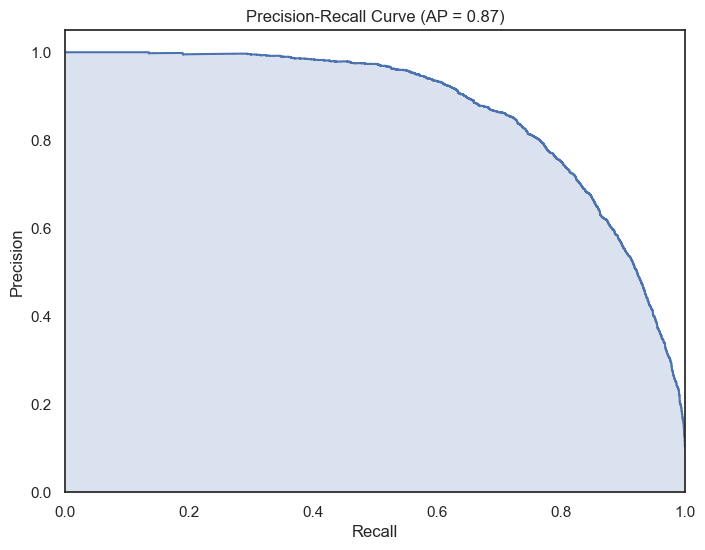

In [30]:
plot_precision_recall(model_lr, X_test, y_test)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


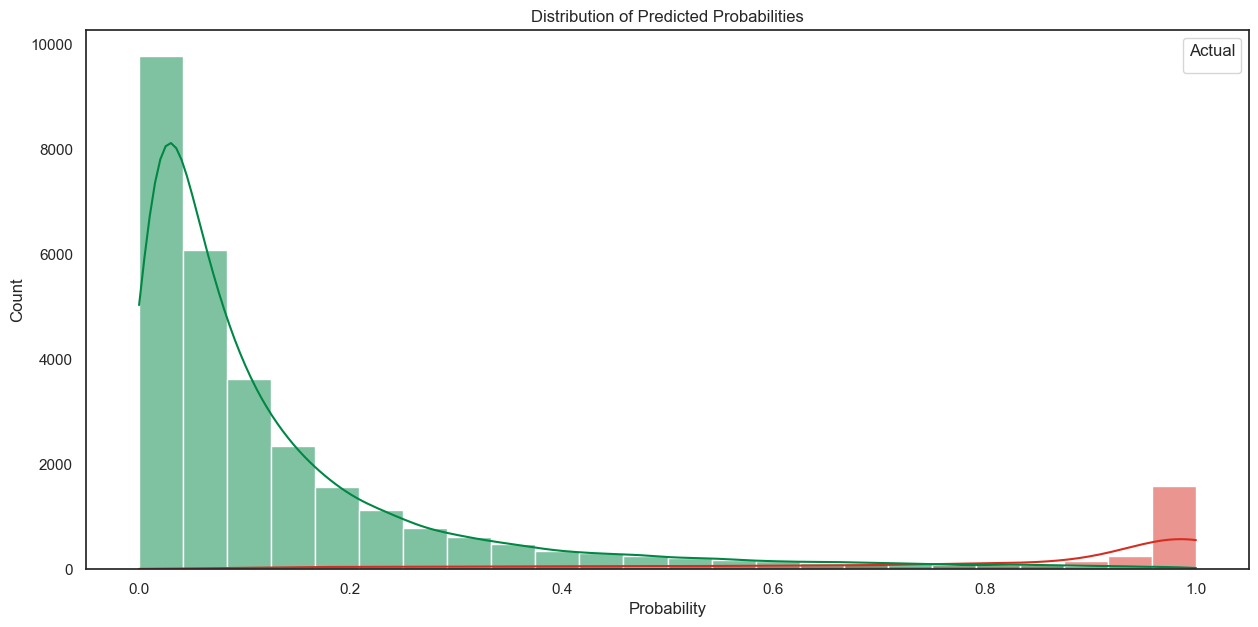

In [31]:
plot_probabilities(model_lr, X_test, y_test, figsize=(15, 7))

### Наивный Байес

In [32]:
model_nb = MultinomialNB(fit_prior=False)
model_nb.fit(X_train, y_train)

compute_metrics(model_nb, X_train, y_train)

{'Accuracy': 0.9420401308923121,
 'Balanced Accuracy': 0.7786722718626237,
 'F1 Score': 0.667925546263825,
 'Precision': 0.7993113095878618,
 'Recall': 0.5736350297320256,
 'GINI': 0.8142005127397889,
 'AUC': 0.9071002563698944}

In [33]:
nb_res = compute_metrics(model_nb, X_test, y_test)
nb_res

{'Accuracy': 0.9368467309080637,
 'Balanced Accuracy': 0.7427834298012936,
 'F1 Score': 0.6163234172387491,
 'Precision': 0.8051818634778276,
 'Recall': 0.4992276799505715,
 'GINI': 0.7689085545646299,
 'AUC': 0.884454277282315}

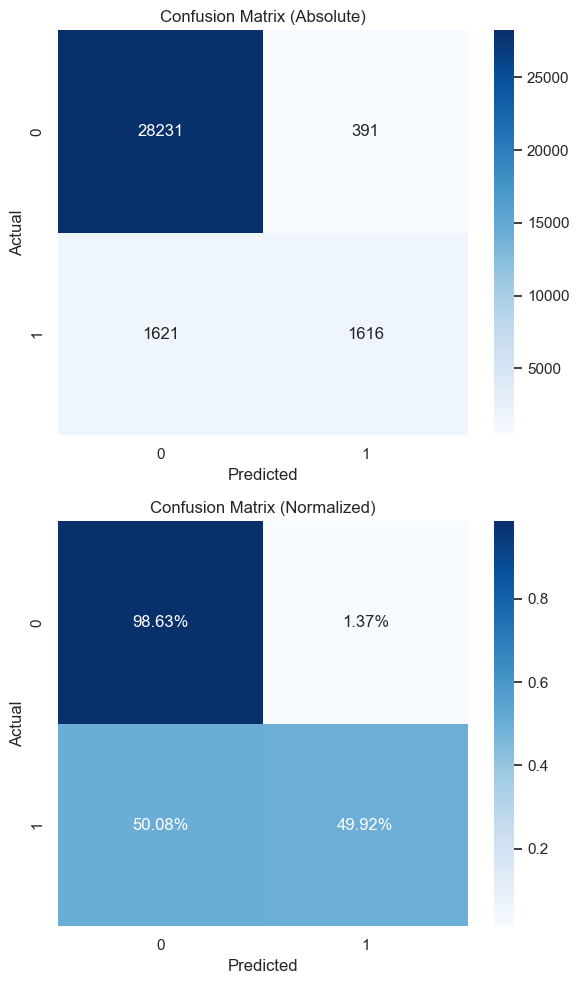

In [34]:
plot_confusion_matrix(model_nb, X_test, y_test)

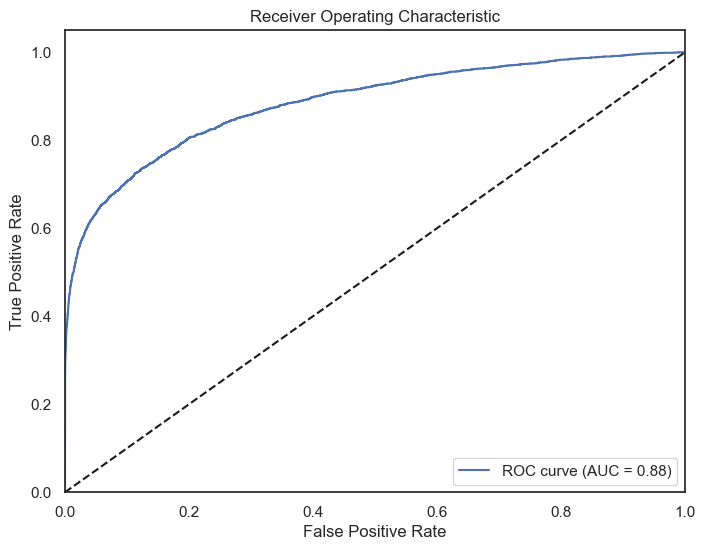

In [35]:
plot_roc(model_nb, X_test, y_test)

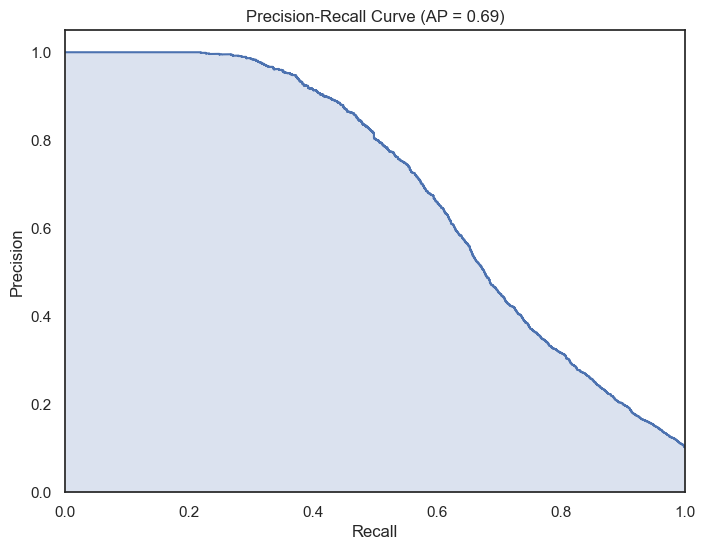

In [36]:
plot_precision_recall(model_nb, X_test, y_test)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


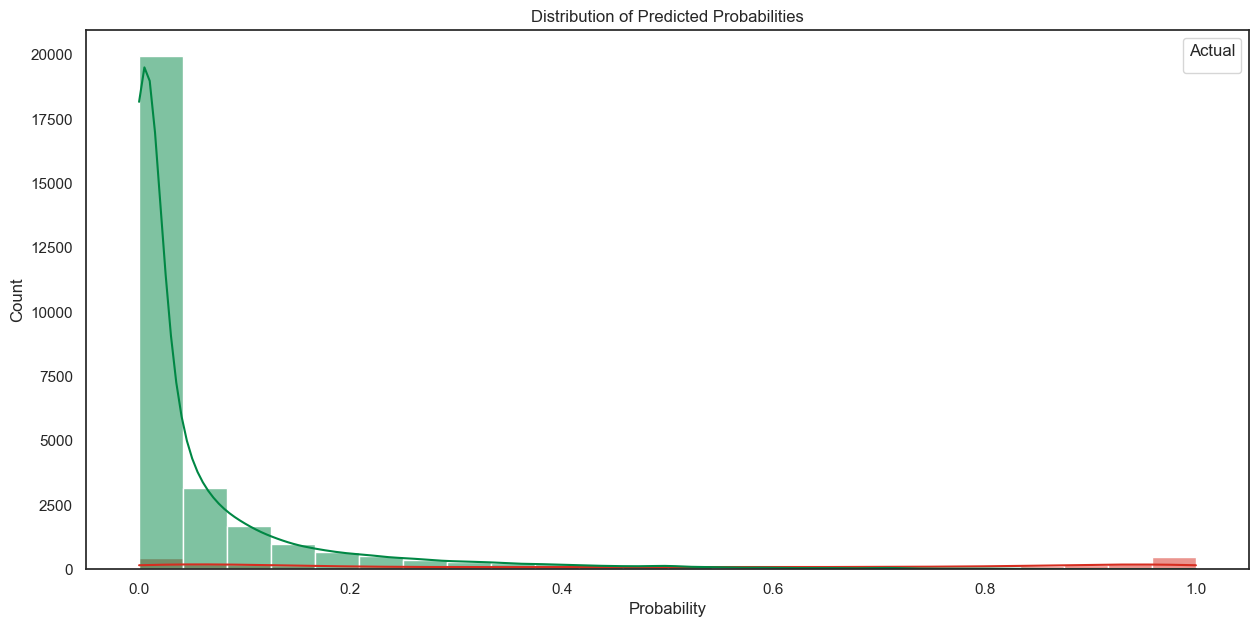

In [37]:
plot_probabilities(model_nb, X_test, y_test, figsize=(15, 7))

## Результаты логистической регрессии при изменении порога классификации

### F1

In [38]:
best_threshold_f1 = find_optimal_threshold(
    model_lr, X_test, y_test, "F1 Score", start=0.5, stop=1, step=0.001)

Iteration 0. Metric: F1 Score. Threshold: 0.5. Best threshold: 0.5 Current metric: 0.7516778523489933. Best metric: 0.7516778523489933
Iteration 1. Metric: F1 Score. Threshold: 0.501. Best threshold: 0.501 Current metric: 0.7517477724468814. Best metric: 0.7517477724468814
Iteration 2. Metric: F1 Score. Threshold: 0.502. Best threshold: 0.502 Current metric: 0.7518528685149601. Best metric: 0.7518528685149601
Iteration 3. Metric: F1 Score. Threshold: 0.503. Best threshold: 0.503 Current metric: 0.7525759032834181. Best metric: 0.7525759032834181
Iteration 4. Metric: F1 Score. Threshold: 0.504. Best threshold: 0.504 Current metric: 0.7531288681061752. Best metric: 0.7531288681061752
Iteration 5. Metric: F1 Score. Threshold: 0.505. Best threshold: 0.505 Current metric: 0.7532002752924983. Best metric: 0.7532002752924983
Iteration 6. Metric: F1 Score. Threshold: 0.506. Best threshold: 0.506 Current metric: 0.7535473205675713. Best metric: 0.7535473205675713
Iteration 7. Metric: F1 Score. 

In [39]:
compute_metrics(model_lr, X_test, y_test, best_threshold_f1)

{'Accuracy': 0.9568096927084968,
 'Balanced Accuracy': 0.8723943790945078,
 'F1 Score': 0.7828968128747239,
 'Precision': 0.800064495324089,
 'Recall': 0.7664504170528267,
 'GINI': 0.9416874131551443,
 'AUC': 0.9708437065775721}

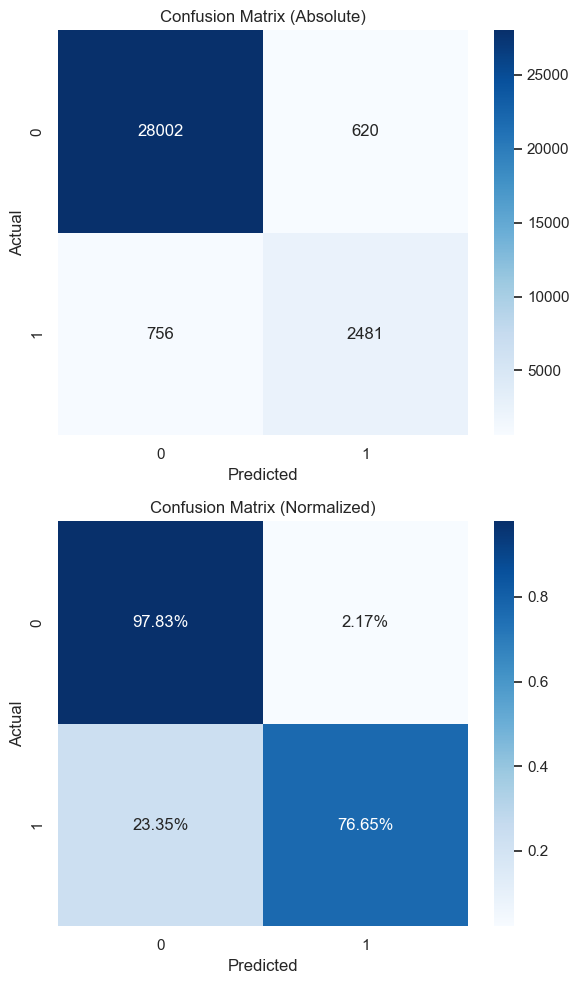

In [40]:
plot_confusion_matrix(model_lr, X_test, y_test, threshold=best_threshold_f1)

### Balanced Accuracy

In [41]:
best_threshold_ba = find_optimal_threshold(
    model_lr, X_test, y_test, "Balanced Accuracy", start=0, stop=1, step=0.001)

Iteration 0. Metric: Balanced Accuracy. Threshold: 0.0. Best threshold: 0.0 Current metric: 0.5. Best metric: 0.5
Iteration 1. Metric: Balanced Accuracy. Threshold: 0.001. Best threshold: 0.001 Current metric: 0.5020788204877367. Best metric: 0.5020788204877367
Iteration 2. Metric: Balanced Accuracy. Threshold: 0.002. Best threshold: 0.002 Current metric: 0.505817203549717. Best metric: 0.505817203549717
Iteration 3. Metric: Balanced Accuracy. Threshold: 0.003. Best threshold: 0.003 Current metric: 0.5099748445251904. Best metric: 0.5099748445251904
Iteration 4. Metric: Balanced Accuracy. Threshold: 0.004. Best threshold: 0.004 Current metric: 0.5143071762979526. Best metric: 0.5143071762979526
Iteration 5. Metric: Balanced Accuracy. Threshold: 0.005. Best threshold: 0.005 Current metric: 0.5193557403395989. Best metric: 0.5193557403395989
Iteration 6. Metric: Balanced Accuracy. Threshold: 0.006. Best threshold: 0.006 Current metric: 0.5236034844213909. Best metric: 0.5236034844213909


In [42]:
compute_metrics(model_lr, X_test, y_test, best_threshold_ba)

{'Accuracy': 0.9097900122414389,
 'Balanced Accuracy': 0.9110242996248201,
 'F1 Score': 0.6727396948303348,
 'Precision': 0.5327321911632101,
 'Recall': 0.9125733704046957,
 'GINI': 0.9416874131551443,
 'AUC': 0.9708437065775721}

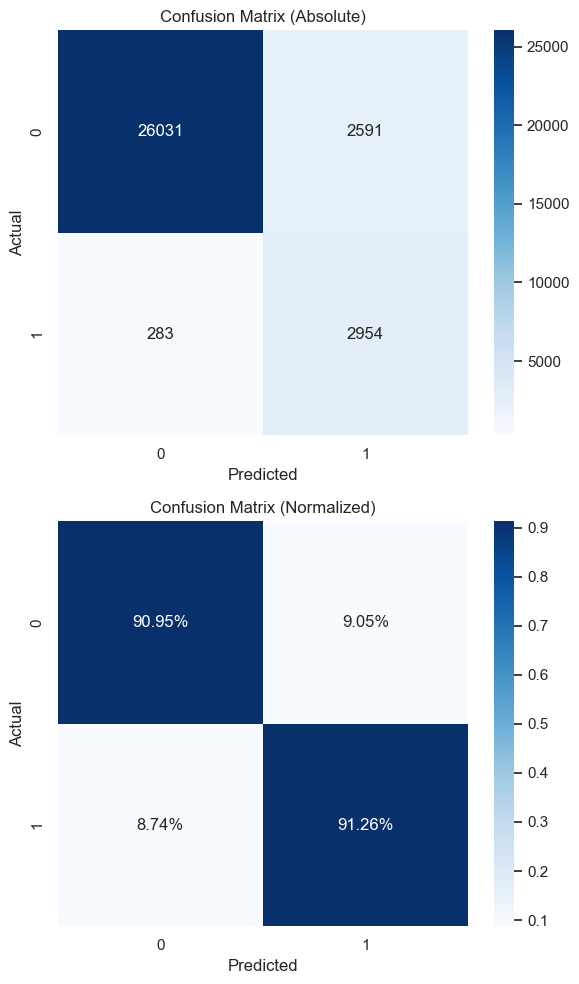

In [43]:
plot_confusion_matrix(model_lr, X_test, y_test, threshold=best_threshold_ba)

## Выводы

Цель проекта состояла в классификации комментариев на позитивные и негативные с целью выявления токсичных комментариев, требующих модерации.

Модель логистической регрессии показала хорошие результаты на тестовой выборке с уровнем метрики F1 Score равным 0.7517. Это означает, что модель достаточно точно предсказывает негативные комментарии и в то же время имеет неплохую полноту и точность.

-   Accuracy (точность) модели составляет 0.9431, что говорит о высоком проценте правильно классифицированных комментариев.
-   Balanced Accuracy (сбалансированная точность) равна 0.9008, что говорит о том, что модель хорошо справляется с предсказанием обоих классов.
-   Precision (точность) равна 0.6752, что означает, что модель правильно классифицирует около 67.52% негативных комментариев относительно всех предсказанных негативных комментариев.
-   Recall (полнота) равен 0.8477, что говорит о том, что модель правильно классифицирует около 84.77% негативных комментариев относительно всех негативных комментариев в данных.
-   GINI и AUC - метрики, связанные с ROC-кривой и площадью под ней, имеют значения 0.9417 и 0.9708 соответственно. Это говорит о высокой разделимости классов моделью.

Помимо этого, был проведен анализ эффективности модели при изменении порогового значения "вероятности" принадлежности к классу:
- При установки порога в 0.671, значение F1 возрастает 0.783, значительно повышая количество верно предсказанных нетоксичных комментариев (до 97.83%), однако падает доля верно определенных токсичных комментариев (до 76.65%). В таком случае модель значительно реже будет ошибочно "банить" пользователей, но чаще пропускать токсичные комментарии. 
- При установлении порога в 0.342, значение F1 падает до 0.672, однако сильно увеличивается сбалансированная точность верно предсказанных нетокстичных и токсичных комментариев - 90.95% и 91.26% соответственно. В этом случае будет достигнут максимальный баланс модели по ошибочному банам и ошибочным пропуском токсичных комментариев.

Таким образом, помимо достижения цели работы, было выявлено два дополнительных варианта использования порогового значения предсказания модели для управлением долей верно определенных типов комментариев и принятием решения по изменению приоритетов работы модераторов.

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Модели обучены
- [x]  Значение метрики *F1* не меньше 0.75
- [x]  Выводы написаны